<a href="https://colab.research.google.com/github/katterine2558/palette-clustering/blob/main/microproyecto1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SOLUCIÓN MICROPROYECTO 1

Por:
Leonardo Almanza
Katerine Arias

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from PIL import Image
import cv2
from sklearn.base import BaseEstimator, TransformerMixin

## 1. Recopilación de imagenes

In [ ]:
# Diccionario con nombre de imagenes
imgs_dict = {'image1': 'imgs/a.y.-jackson_smart-river-alaska-1945.jpg',
             'image2': 'imgs/abraham-manievich_camden-1923.jpg',
             'image3':'imgs/adriaen-brouwer_farmers-fight-party.jpg',
             'image4':'imgs/aldemir-martins_baiana-1980.jpg',
             'image5': 'imgs/allen-jones_crazy-horse-1976.jpg',
             'image6': 'imgs/andy-warhol_arnold-schwarzenegger-1977.jpg',
             'image7':'imgs/giorgio-vasari_boccaccio-dante-petrarca.jpg',
             'image8':'imgs/hiroshige_bay-at-kominato-in-awa-province.jpg'}

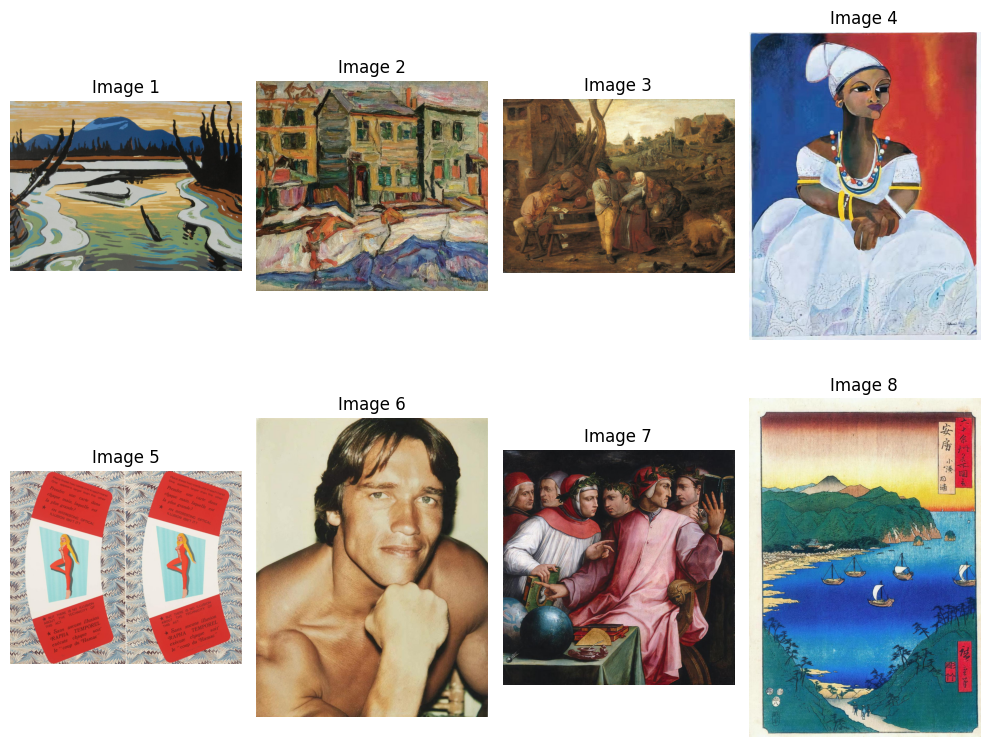

In [ ]:
#Plotea imagenes seleccionadas
def plot_images_grid(image_paths, grid_size=(2, 4), figsize=(10, 8)):
    """
    Plotea una lista de imágenes en una grilla.

    Args:
        image_paths (list): Lista de rutas a las imágenes.
        grid_size (tuple): Tamaño de la grilla (filas, columnas).
        figsize (tuple): Tamaño de la figura.
    """
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=figsize)
    axes = axes.flatten()

    for i, img_path in enumerate(image_paths):
        if i < len(axes):
            try:
                img = Image.open(img_path)
                axes[i].imshow(img)
                axes[i].set_title(f"Image {i+1}")
                axes[i].axis('off')
            except FileNotFoundError:
                axes[i].set_title(f"Image {i+1} not found")
                axes[i].axis('off')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Plot de imagenes
image_paths_list = list(imgs_dict.values())
plot_images_grid(image_paths_list)

## 2. Preparación de los datos

In [ ]:
#Obtiene la imagen
class Image:
  def __init__(self):
      self.image = None

#Carga la imagen
class ImageReader(BaseEstimator, TransformerMixin):
  def __init__(self, image):
    self.image = image

  def fit(self, X, y=None):
    return self

  def transform(self, path):
    img = cv2.imread(path)
    return img

#Redimensiona la imagen
class ImageResizer(BaseEstimator, TransformerMixin):
  def __init__(self, image, max_side=100):
    self.image = image
    self.max_side = max_side

  def fit(self, X, y=None):
    return self

  def transform(self, X):
      scale = self._calc_scale(X)
      if scale != 1:
          new_w = int(X.shape[1] * scale)
          new_h = int(X.shape[0] * scale)
          return cv2.resize(X, (new_w, new_h), interpolation=cv2.INTER_AREA)
      return X

  def _calc_scale(self, img):

      max_area = self.max_side ** 2
      h, w = img.shape[:2]
      img_area = h * w
      if img_area > max_area:
          factor = np.sqrt(max_area / float(img_area))
      else:
          factor = 1.0
      return factor

#Convierte a RGB
class ConvertToRGB(BaseEstimator, TransformerMixin):

  def __init__(self, image):
      self.image = image

  def fit(self, X, y=None):
    return self

  def transform(self, X):

    rgb_img = cv2.cvtColor(X, cv2.COLOR_BGR2RGB)
    self.image.image = rgb_img
    return rgb_img.reshape((-1, 3))


#Normaliza la imagen
class RGBNormalizer(BaseEstimator, TransformerMixin):

  def __init__(self, image):
      self.image = image

  def fit(self, X, y=None):
    return self

  def transform(self,X):
    return X / 255


## 3. Construcción de pipeline

## 4. Construcción del modelo

In [ ]:
def find_optimal_clusters_kmeans(data, param_grid, min_silhouette_score):
    """
    Encuentra el modelo óptimo de K-Means basado en Silhouette Score e Inertia
    """

    scores_silhouette, scores_inertia, models = [], [], []

    for n_clusters in param_grid['n_clusters']:
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=500, random_state=0)
        kmeans.fit(data)
        labels = kmeans.labels_
        num_clusters = len(set(labels))

        if num_clusters > 1:
            score_silhouette = silhouette_score(data, labels)
            score_inertia = kmeans.inertia_
            scores_silhouette.append(score_silhouette)
            scores_inertia.append(score_inertia)
            models.append(kmeans)
        else:
            scores_silhouette.append(-1)
            scores_inertia.append(0)
            models.append(kmeans)

    # Selección del mejor modelo
    best_score = max(scores_silhouette)
    if best_score > min_silhouette_score:
        print(f'Best silhouette score: {best_score:.4f}')
        best_model_index = scores_silhouette.index(best_score)
        print(f"Selected based on Silhouette Score (k={param_grid['n_clusters'][best_model_index]})")
        score_type = 'silhouette'
    else:
        # Si ningún Silhouette es suficientemente bueno, usar Inertia
        valid_inertias = [inertia for inertia in scores_inertia if inertia > 0]
        if valid_inertias:
            best_score = min(valid_inertias)
            best_model_index = scores_inertia.index(best_score)
            print(f'Best inertia score: {best_score:.2f}')
            print(f"Selected based on Inertia (k={param_grid['n_clusters'][best_model_index]})")
            score_type = 'inertia'

    best_model = models[best_model_index]

    return {
        'best_model': best_model,
        'best_score': best_score,
        'score_type': score_type,
        'silhouette_scores': scores_silhouette,
        'inertia_scores': scores_silhouette
    }

In [ ]:
def plot_silhouette_score(best_k):

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-1, 1])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()



/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Best silhouette score: 0.5254
Selected based on Silhouette Score (k=8)


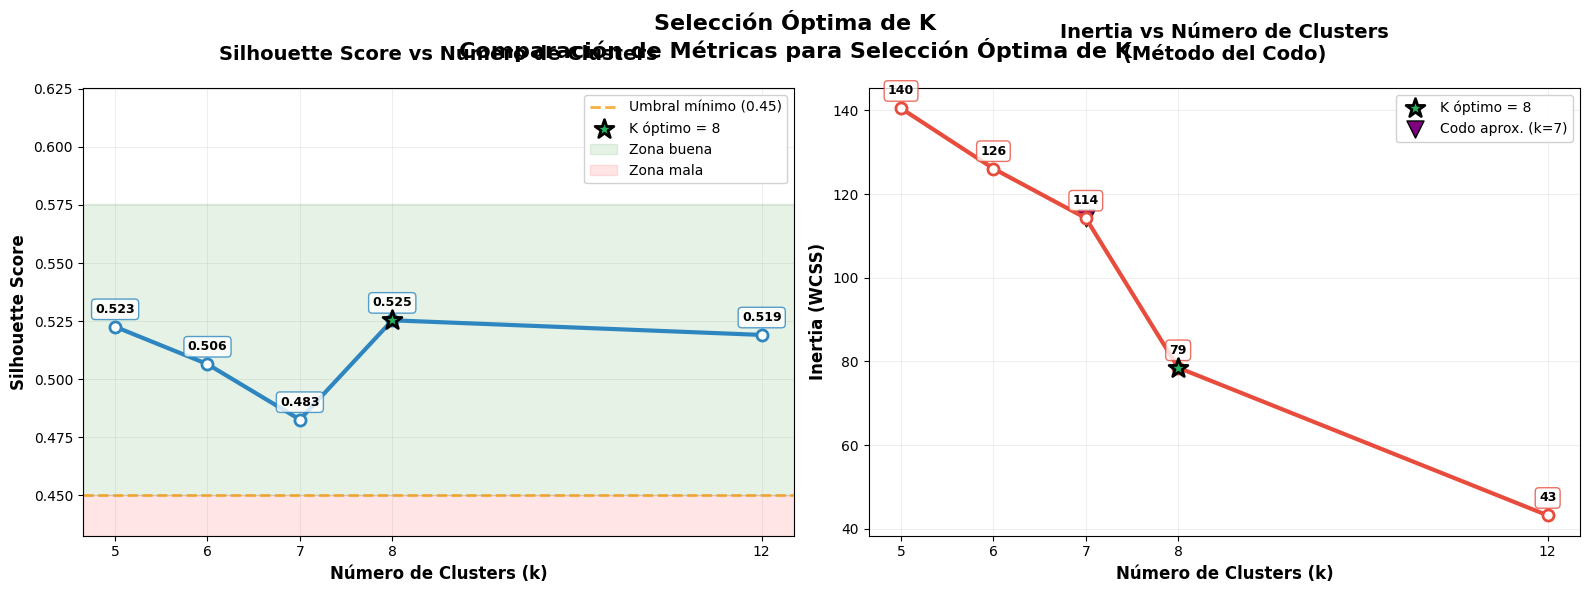

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Best inertia score: 60.57
Selected based on Inertia (k=12)


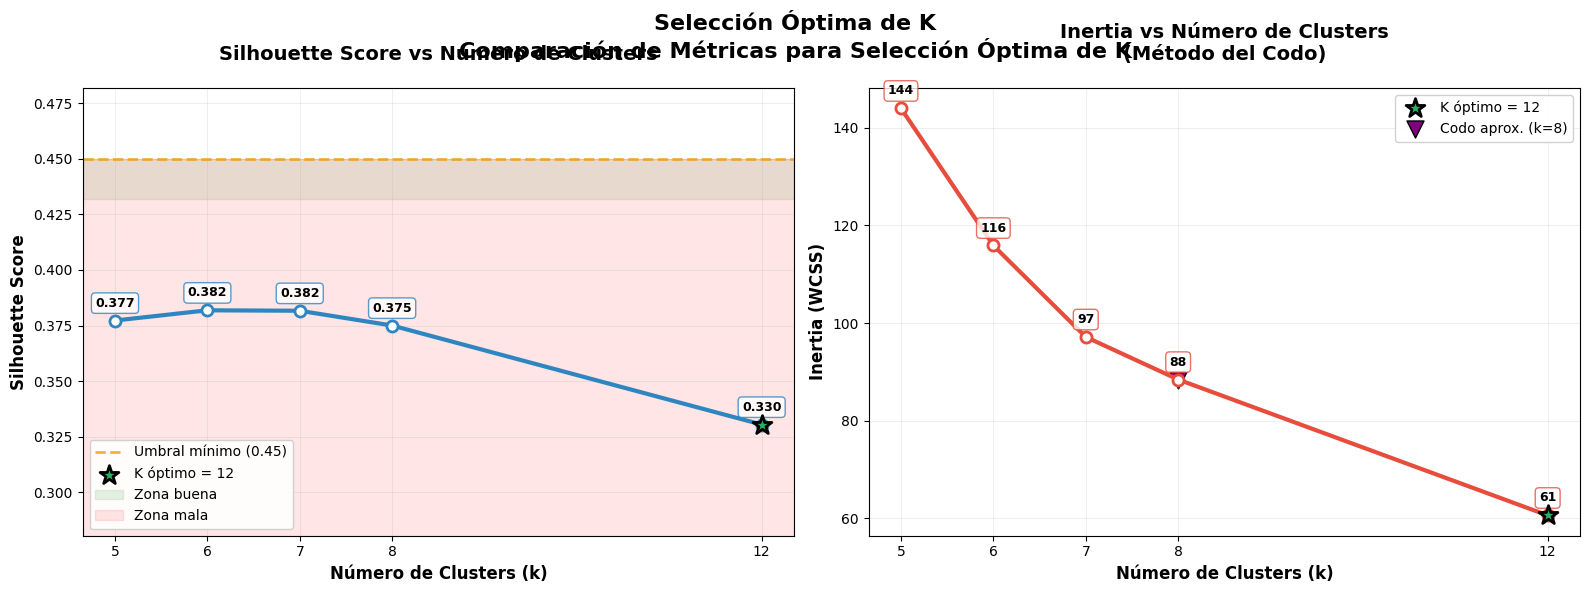

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Best silhouette score: 0.4948
Selected based on Silhouette Score (k=5)


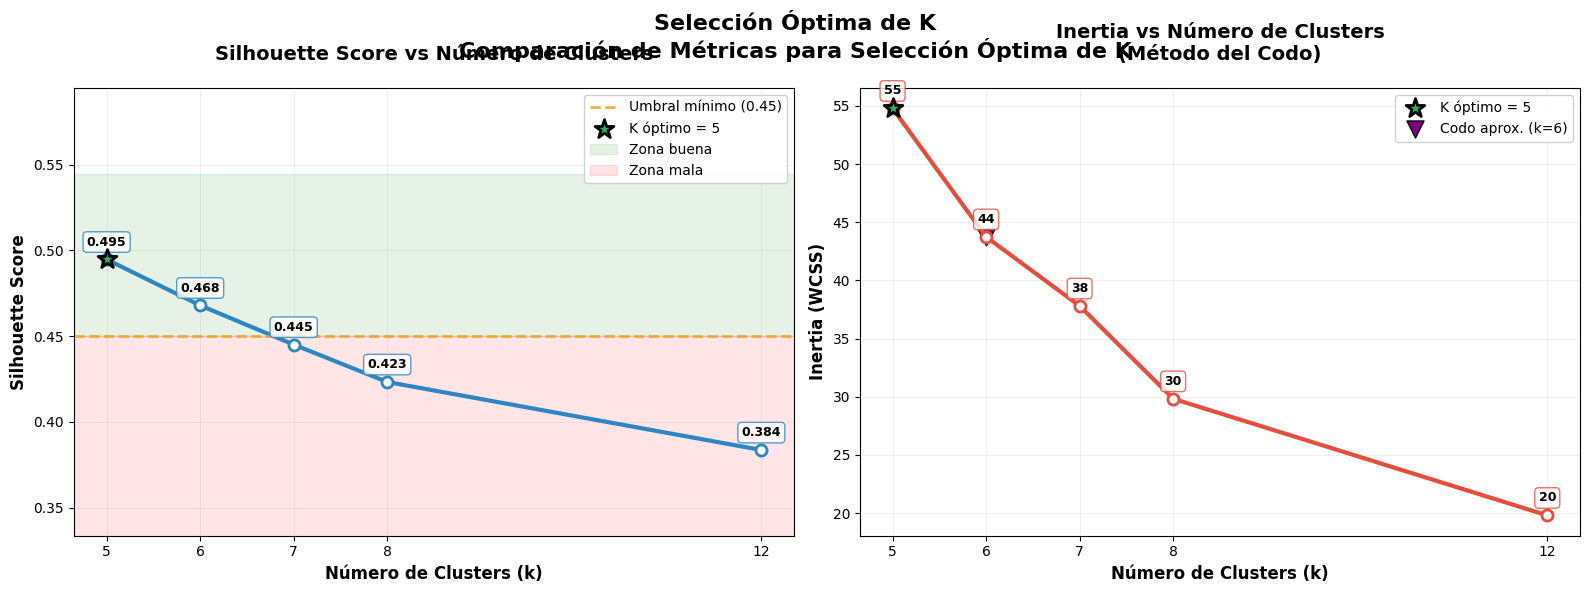

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Best silhouette score: 0.7070
Selected based on Silhouette Score (k=5)


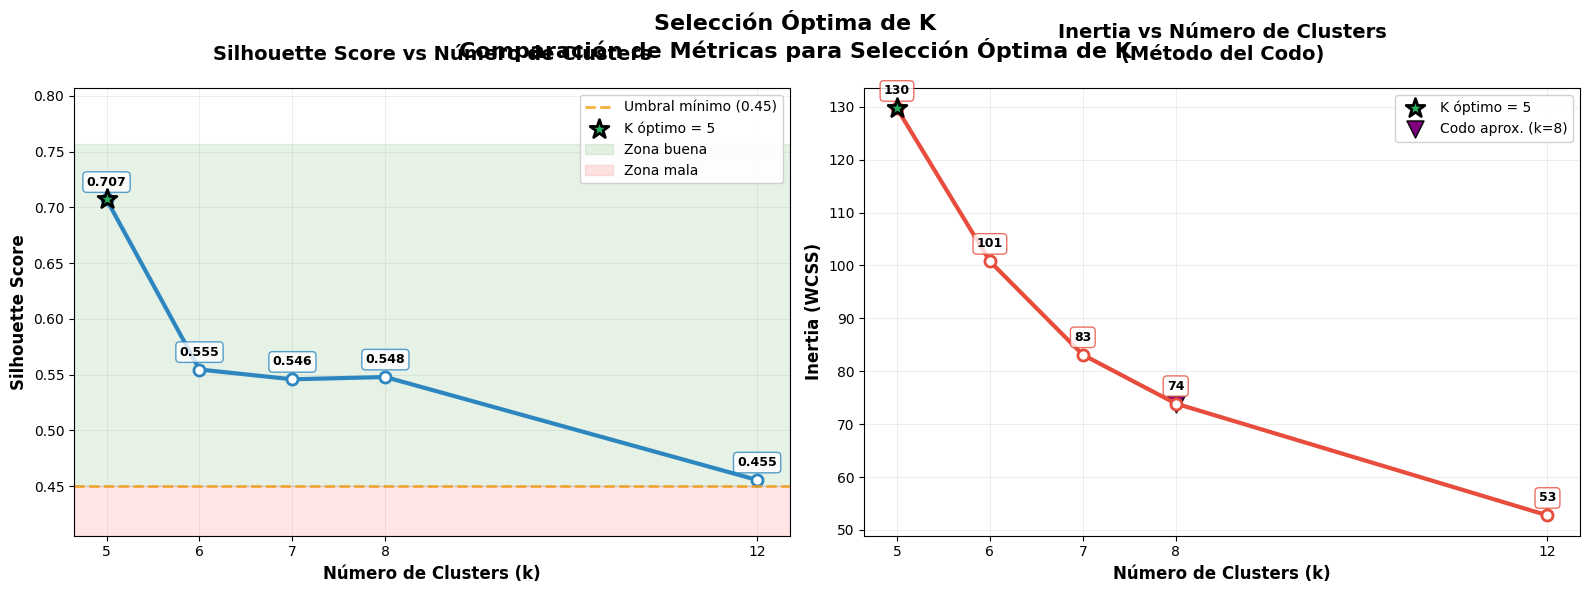

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Best silhouette score: 0.5539
Selected based on Silhouette Score (k=8)


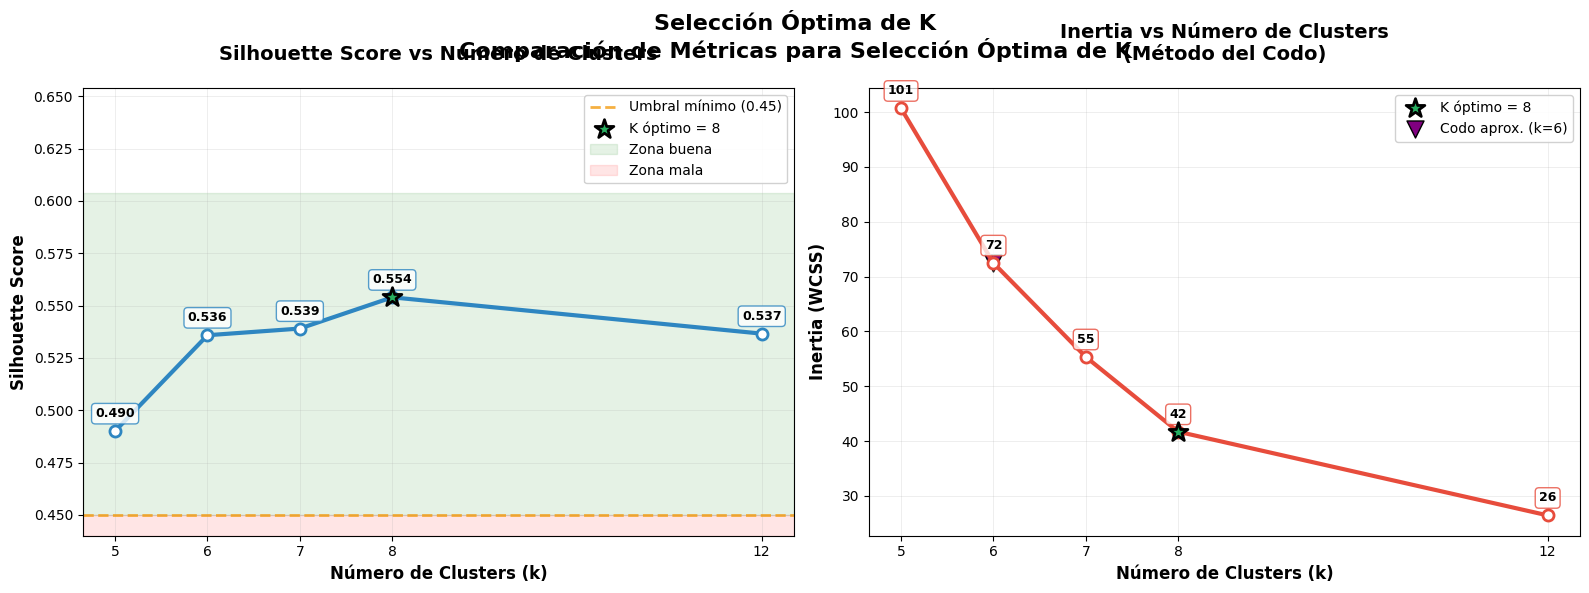

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Best silhouette score: 0.5451
Selected based on Silhouette Score (k=5)


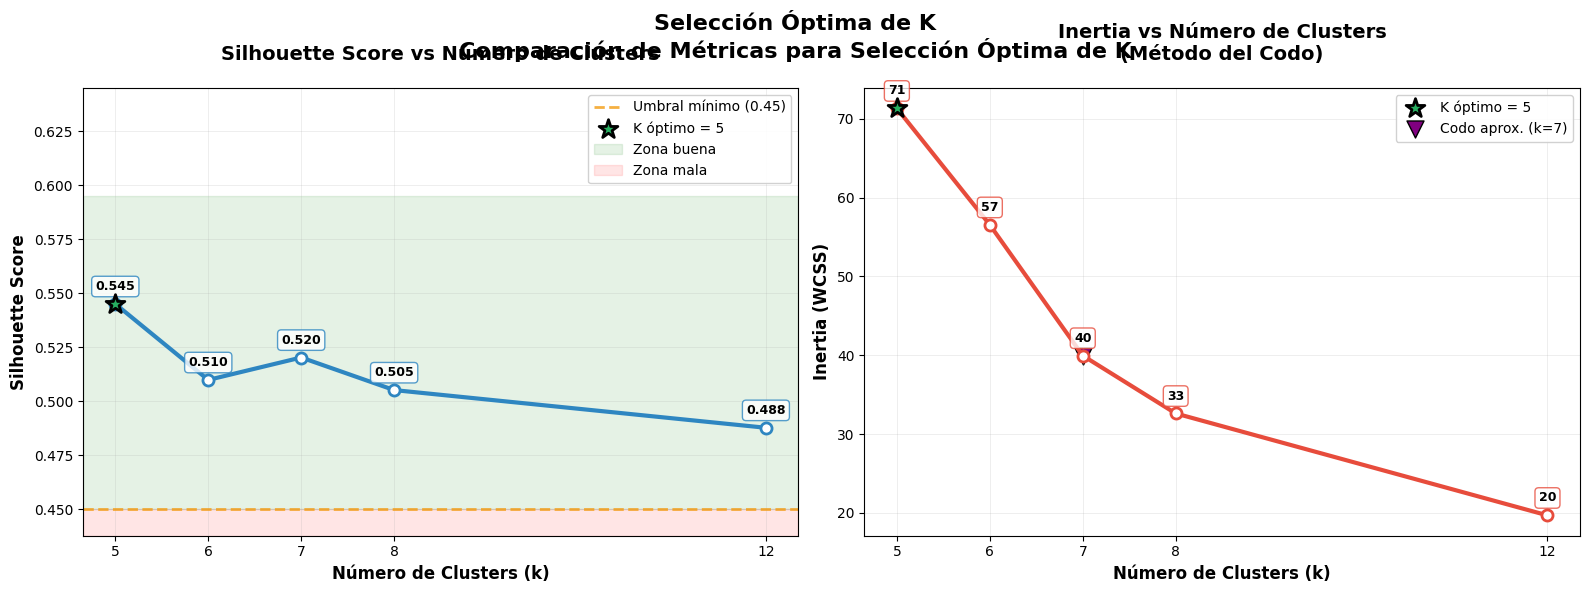

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Best silhouette score: 0.5043
Selected based on Silhouette Score (k=6)


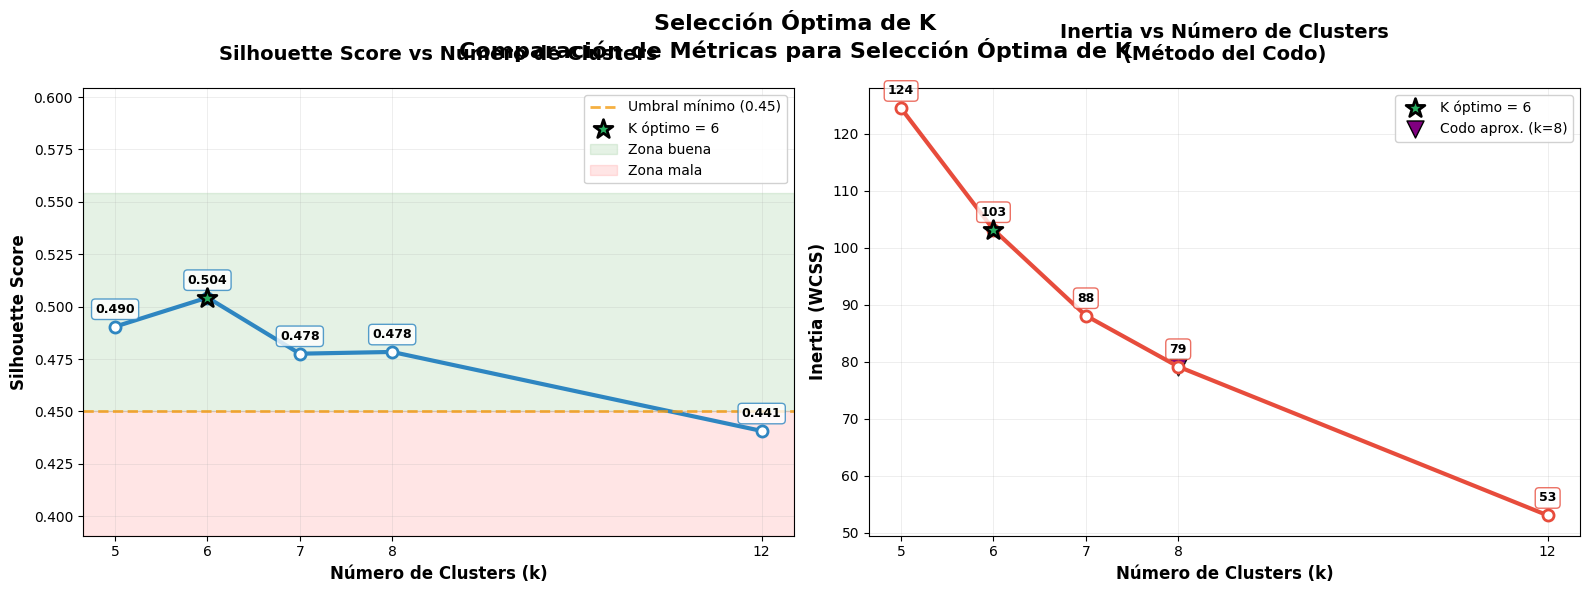

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Best silhouette score: 0.5028
Selected based on Silhouette Score (k=6)


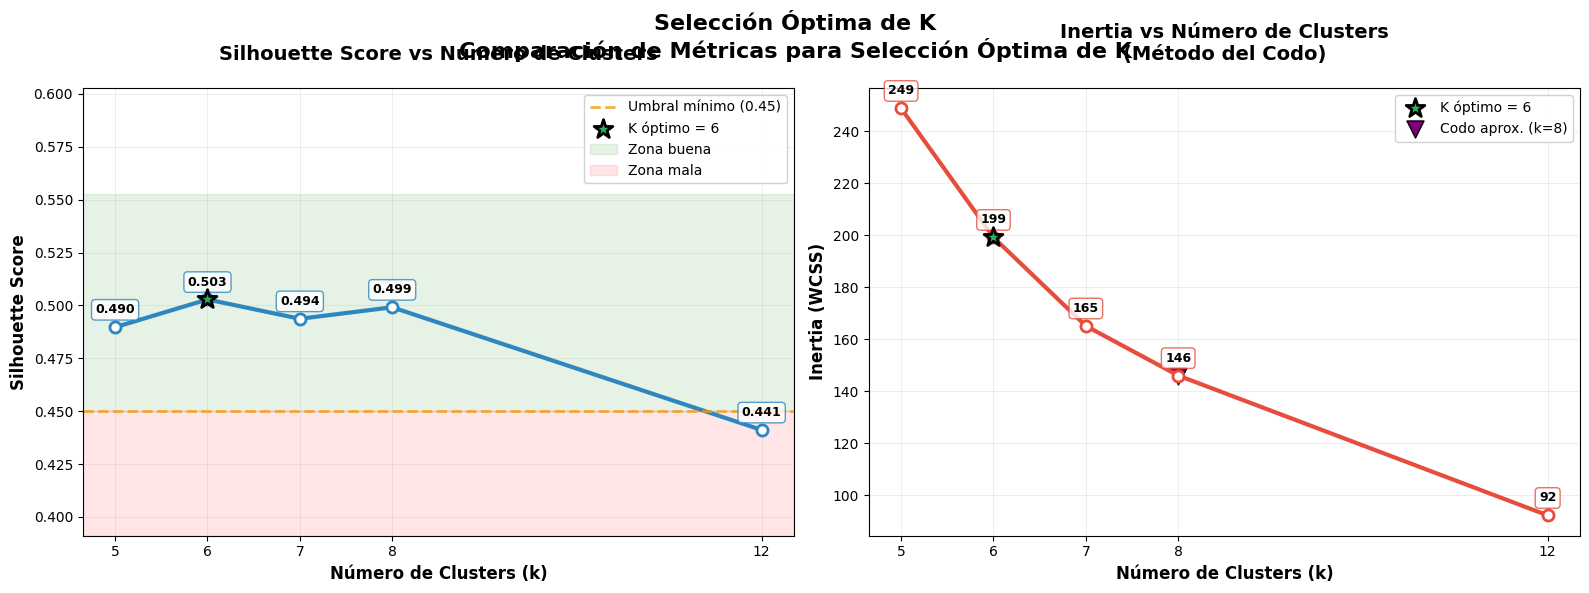

In [ ]:
param_grid = {
    "n_clusters": [5, 6, 7, 8, 12]
}
min_silhoutte_score = 0.45
for num_imagen, path in imgs_dict.items():
  image = Image()
  steps = [
      ('image_reader', ImageReader(image)),
      ('image_resizer', ImageResizer(image)),
      ('resizedimage_to_rgb', ConvertToRGB(image)),
      ('rgb_normalizer', RGBNormalizer(image))
  ]
  pipeline = Pipeline(steps)
  img_rgb = pipeline.transform(path)

  best_kmeans, best_score_kmeans, metrics_data  = find_optimal_clusters_kmeans(img_rgb,param_grid,min_silhoutte_score)
  plot_k_selection_metrics(metrics_data['k_values'], metrics_data['silhouette_scores'], metrics_data['inertia_scores'],min_silhoutte_score, metrics_data['best_k'], 'Selección Óptima de K')